In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from river import tree
from river import drift
from river import stream

print("Libraries loaded.")

Libraries loaded.


In [2]:
DATA_PATH = "../data/nonlinear_sudden_rollingtorus_noise_and_redunce.csv"

df = pd.read_csv(DATA_PATH)

X = df.drop(columns=["label"])
y = df["label"]

In [3]:
model = tree.HoeffdingTreeClassifier()

adwin = drift.ADWIN()

drift_points = []
correct_predictions = []

print("Model + ADWIN initialized.")

Model + ADWIN initialized.


In [4]:
for i, (xi, yi) in enumerate(stream.iter_pandas(X, y)):
    
    y_pred = model.predict_one(xi)
    
    if y_pred is None:
        error = 0
    else:
        error = int(y_pred != yi)
        correct_predictions.append(int(y_pred == yi))
    
    # Update drift detector with error
    adwin.update(error)
    
    if adwin.drift_detected:
        drift_points.append(i)
    
    model.learn_one(xi, yi)

print("Streaming complete.")
print("Detected drift points:", drift_points)

Streaming complete.
Detected drift points: [2847, 20063, 21343, 40031, 40991, 54015, 60031, 60607, 61055, 71839, 80063, 82655, 84319, 91295, 97983]


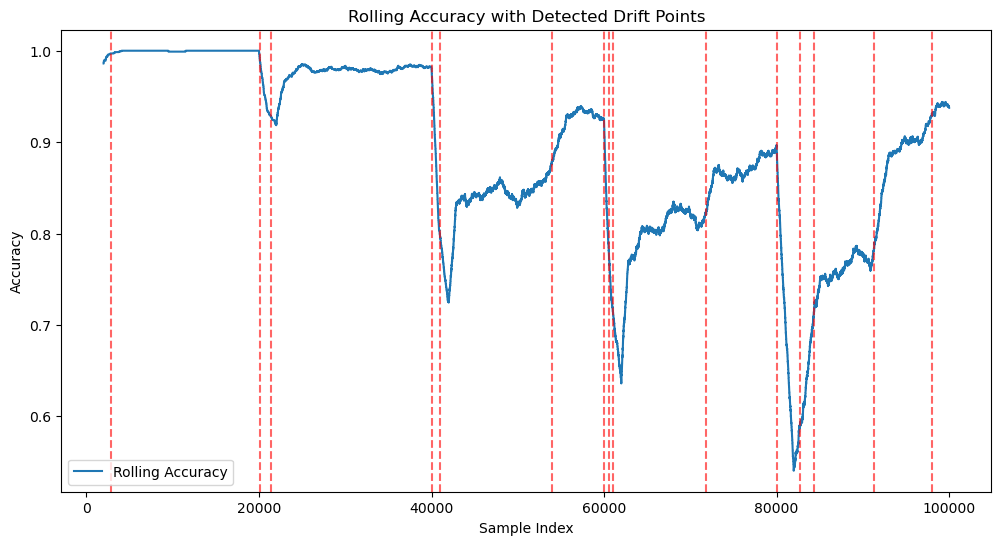

In [5]:
window_size = 2000
rolling_acc = pd.Series(correct_predictions).rolling(window_size).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling_acc, label="Rolling Accuracy")

for dp in drift_points:
    plt.axvline(dp, color="red", linestyle="--", alpha=0.6)

plt.title("Rolling Accuracy with Detected Drift Points")
plt.xlabel("Sample Index")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [6]:
from river import tree
from river import drift
from river import stream

model = tree.HoeffdingTreeClassifier()
adwin = drift.ADWIN()

drift_points = []
correct_predictions = []

for i, (xi, yi) in enumerate(stream.iter_pandas(X, y)):
    
    y_pred = model.predict_one(xi)
    
    if y_pred is None:
        error = 0
        correct_predictions.append(0)
    else:
        error = int(y_pred != yi)
        correct_predictions.append(int(y_pred == yi))
    
    adwin.update(error)
    
    if adwin.drift_detected:
        drift_points.append(i)
        
        # 🔥 RESET MODEL
        model = tree.HoeffdingTreeClassifier()
    
    model.learn_one(xi, yi)

print("Streaming complete.")
print("Detected drift points:", drift_points)


Streaming complete.
Detected drift points: [2847, 5631, 11711, 17951, 20063, 21279, 24607, 26463, 29855, 30975, 31807, 40063, 42751, 45343, 47615, 50687, 52671, 55039, 60031, 63583, 66207, 77631, 79967, 80447, 82239, 87327, 89407, 92991]


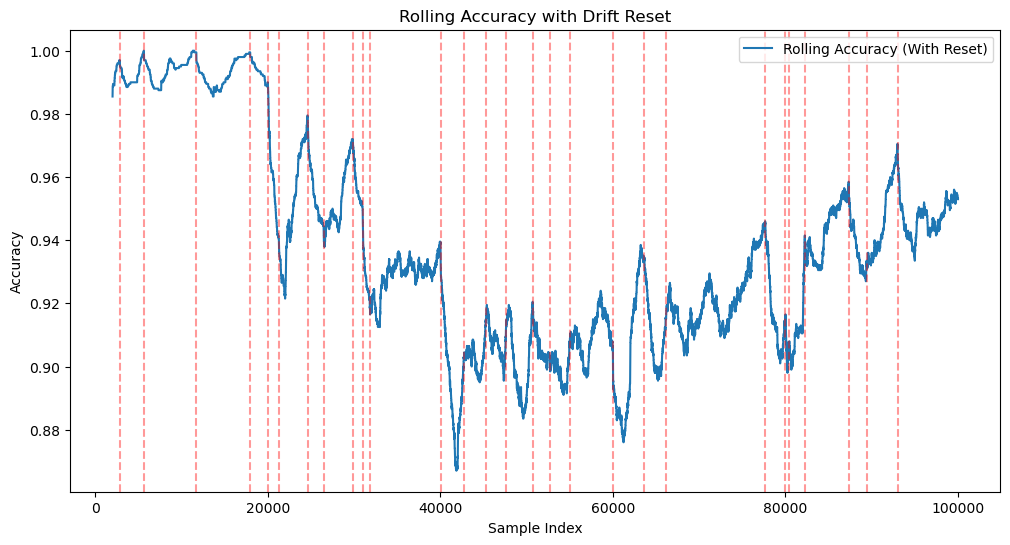

In [7]:
window_size = 2000

rolling_acc = pd.Series(correct_predictions).rolling(window_size).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling_acc, label="Rolling Accuracy (With Reset)")

for dp in drift_points:
    plt.axvline(dp, color="red", linestyle="--", alpha=0.4)

plt.title("Rolling Accuracy with Drift Reset")
plt.xlabel("Sample Index")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [8]:
from river import tree
from river import drift
from river import stream

model = tree.HoeffdingTreeClassifier()
adwin_tuned = drift.ADWIN(delta=0.0005)

drift_points_tuned = []
correct_predictions_tuned = []

for i, (xi, yi) in enumerate(stream.iter_pandas(X, y)):
    
    y_pred = model.predict_one(xi)
    
    if y_pred is None:
        error = 0
        correct_predictions_tuned.append(0)
    else:
        error = int(y_pred != yi)
        correct_predictions_tuned.append(int(y_pred == yi))
    
    adwin_tuned.update(error)
    
    if adwin_tuned.drift_detected:
        drift_points_tuned.append(i)
        model = tree.HoeffdingTreeClassifier()
    
    model.learn_one(xi, yi)

print("Tuned Drift Points:", drift_points_tuned)
print("Total Drift Count:", len(drift_points_tuned))


Tuned Drift Points: [3455, 9887, 15103, 20063, 21599, 23231, 26591, 28735, 29215, 30815, 36703, 38495, 39775, 50751, 53151, 55423, 59935, 60383, 67007, 70655, 72799, 80063, 91903, 93343, 95103]
Total Drift Count: 25


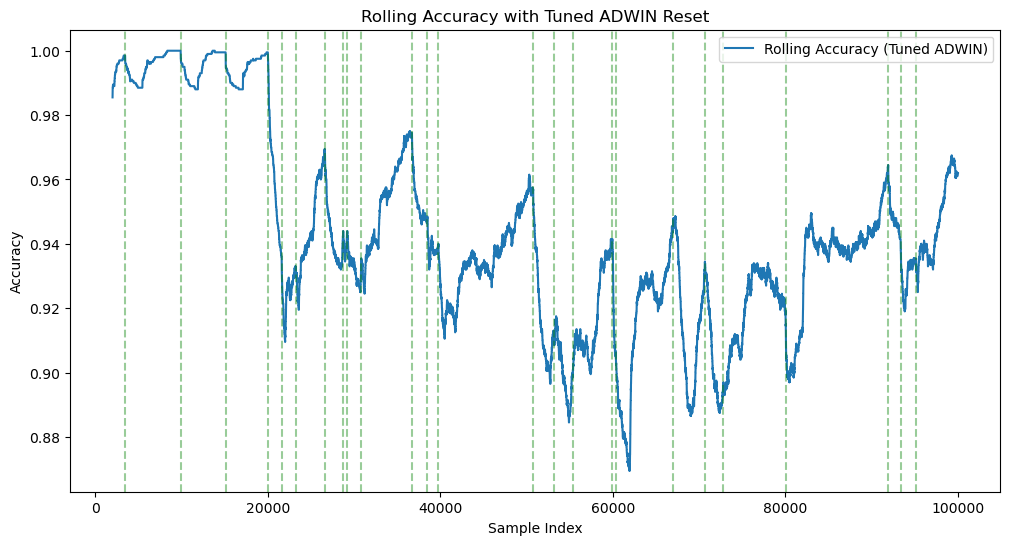

In [9]:
window_size = 2000
rolling_acc_tuned = pd.Series(correct_predictions_tuned).rolling(window_size).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling_acc_tuned, label="Rolling Accuracy (Tuned ADWIN)")

for dp in drift_points_tuned:
    plt.axvline(dp, color="green", linestyle="--", alpha=0.4)

plt.title("Rolling Accuracy with Tuned ADWIN Reset")
plt.xlabel("Sample Index")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

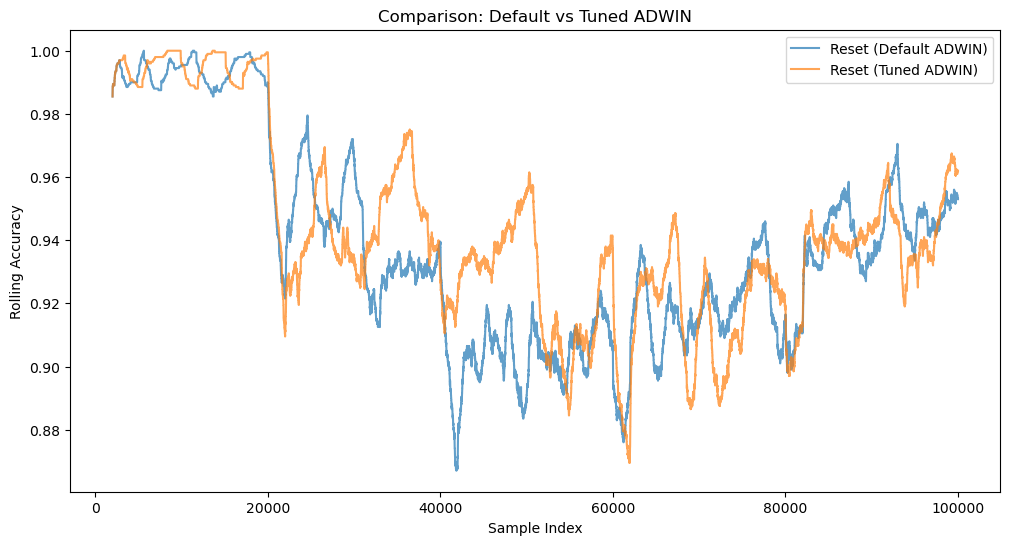

In [10]:
plt.figure(figsize=(12,6))

plt.plot(rolling_acc, label="Reset (Default ADWIN)", alpha=0.7)
plt.plot(rolling_acc_tuned, label="Reset (Tuned ADWIN)", alpha=0.7)

plt.title("Comparison: Default vs Tuned ADWIN")
plt.xlabel("Sample Index")
plt.ylabel("Rolling Accuracy")
plt.legend()
plt.show()


In [11]:
def evaluate_performance(correct_predictions, name):
    series = pd.Series(correct_predictions)
    rolling = series.rolling(2000).mean()
    
    final_acc = series.mean()
    mean_rolling = rolling.mean()
    min_rolling = rolling.min()
    
    print(f"\n{name}")
    print("-" * 40)
    print(f"Final Cumulative Accuracy: {final_acc:.4f}")
    print(f"Mean Rolling Accuracy:      {mean_rolling:.4f}")
    print(f"Worst Rolling Accuracy:     {min_rolling:.4f}")
    
    return {
        "final_acc": final_acc,
        "mean_rolling": mean_rolling,
        "min_rolling": min_rolling
    }

In [12]:
baseline_metrics = evaluate_performance(correct_predictions, "Reset (Default ADWIN)")
tuned_metrics = evaluate_performance(correct_predictions_tuned, "Reset (Tuned ADWIN)")


Reset (Default ADWIN)
----------------------------------------
Final Cumulative Accuracy: 0.9386
Mean Rolling Accuracy:      0.9381
Worst Rolling Accuracy:     0.8670

Reset (Tuned ADWIN)
----------------------------------------
Final Cumulative Accuracy: 0.9436
Mean Rolling Accuracy:      0.9431
Worst Rolling Accuracy:     0.8695
